In [4]:
import numpy as np
from scipy.linalg import solve
from numpy.linalg import cholesky
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import pandas as pd

# import sklearn timeseries split
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
class DeepGP(object):
    def __init__(self, x_train, y_train, x_test, layers, params):

        # Network
        self.layers = layers # Depth

        # Hyperparameters on weights and biases
        self.params = params
        self.sigma_w = self.params[0]
        self.sigma_b = self.params[1]

        self.n_train, self.dims = x_train.shape
        self.x_train = x_train
        self.y_train = y_train

        self.n_test = x_test.shape[0]
        self.x_test = x_test

        self.N = self.n_train + self.n_test
        # Store train and test data in Block Matrix 
        self.data = np.zeros((self.N, self.dims))
        self.data[:self.n_train, ] = self.x_train
        self.data[self.n_train:, ] = self.x_test

        # Task: Fill K Matrix
        self.K = np.zeros((self.N, self.N, self.layers))
        self.theta = np.zeros((self.N, self.N, self.layers))

    def fill_first_layer(self):
        # corresponds to rescaled and bumped outer prod of data
        self.K[...,0] = self.sigma_b + self.sigma_w*np.outer(self.data, self.data.T)
    
    def fill_layers(self):
        # Fill remainging layers or recurrence levels
        for layer in range(1, self.layers):
            for i in range(self.N):
                for j in range(self.N):
                    # Get previous layer kernel values for Recurrence 
                    K_ii = self.K[i,i,layer-1]
                    K_ij = self.K[i,j,layer-1]
                    K_jj = self.K[j,j,layer-1]
                    theta = self.theta[i,j,layer-1]

                    new_K_ij, new_theta = self.ReLuRecur(K_ii, K_ij, K_jj, theta)

                    # symmetric update of covariance matrix for current layer
                    self.K[i,j,layer] = new_K_ij
                    self.K[j,i,layer] = new_K_ij
                    self.theta[i,j,layer] = new_theta
                    self.theta[j,i,layer] = new_theta


    def ReLuRecur(self, K_ii, K_ij, K_jj, theta_ij):
        """
        ReLu activation function
        """

        angle_= np.sin(theta_ij) + (np.pi - theta_ij) * np.cos(theta_ij)
        new_K_ij = self.sigma_b + self.sigma_w / (2*np.pi) * np.sqrt(K_ii * K_jj) * angle_ 

        corr = K_ij /np.sqrt(K_ii * K_jj)
        if corr > 1:
            corr = 1
        new_theta = np.arccos(corr)
       
        return new_K_ij, new_theta
               

    def train(self):
        # update params
        self.sigma_w = self.params[0]
        self.sigma_b = self.params[1]

        self.fill_first_layer()
        self.fill_layers()

    
    def predict(self):
        # Form a block of 4 matrices
        K_DD = self.K[:self.n_train, :self.n_train, -1]
        K_TD = self.K[self.n_train:, :self.n_train, -1]
        K_TT = self.K[self.n_train:, self.n_train:, -1]

        # Add constant noise term to diagonal
        noisy_k = K_DD + 1e-5*np.eye(self.n_train)
        noisy_k_inv = np.linalg.inv(noisy_k)

        predicted_mean = K_TD @ noisy_k_inv @ self.y_train
        predicted_cov = K_TT - K_TD @ noisy_k_inv @ K_TD.T

        return predicted_mean, predicted_cov


def log_likelihood(GP: DeepGP):
    # Numerically more stable implementation of NLL as described
    # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
    # 2.2, Algorithm 2.1.
    y = GP.y_train

    K = GP.K[:GP.n_train, :GP.n_train, -1] 
    K += np.eye(K.shape[0])

    L = cholesky(K)

    S1 = solve_triangular(L, y, lower=True)
    S2 = solve_triangular(L.T, S1, lower=False)

    return np.sum(
            - np.log(np.diag(L)) 
            - 0.5 * y.T.dot(S2) 
            - 0.5* GP.n_train * np.log(2*np.pi)
    )


def MH(GP: DeepGP, iter = 100):
    params = []
    ll = []

    params.append(GP.params)
    ll.append(log_likelihood(GP))

    log_params = np.log(GP.params)

    bandwith_w = np.log(10)
    bandwith_b = np.log(10)

    GP.train()
    prev_ll = log_likelihood(GP) 
    
    for i in range(iter):
        proposal_w = np.random.normal(0, bandwith_w, 1)
        proposal_b = np.random.normal(0, bandwith_b, 1)
        

        proposal = np.array([proposal_w, proposal_b]).flatten()
        proposal += log_params    

        GP.params = np.exp(proposal)
        GP.train()

        
        new_ll = log_likelihood(GP)

        if new_ll > prev_ll or np.exp(new_ll - prev_ll) > np.random.random():
            prev_ll = new_ll
            log_params = proposal

            params.append(GP.params)
            ll.append(new_ll)

    return params, ll



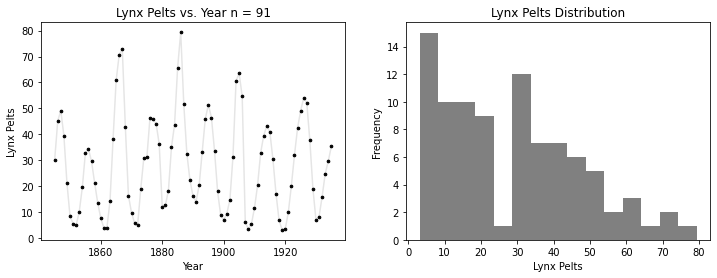

In [124]:
# Load the data
lynx= pd.read_csv('lynxhare.csv')
lynx.head()

# subplts
fig, ax = plt.subplots(1,2, figsize=(12,4))


# Plot the data
ax[0].plot(lynx.Year, lynx.Lynx, color = 'black', label = 'Lynx Pelts', alpha = 0.1)
#plt.plot(lynx.Year, lynx.Lynx)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Lynx Pelts')
ax[0].set_title(f'Lynx Pelts vs. Year n = {lynx.shape[0]}')


# plot distribution
ax[1].hist(lynx.Lynx, bins = 15, color = 'grey', label = 'Lynx Pelts')
# scatter
ax[0].scatter(lynx.Year, lynx.Lynx, color = 'black', label = 'Lynx Pelts', alpha = 1, marker = 'o', s = 7)
# label the axes
ax[1].set_xlabel('Lynx Pelts')
ax[1].set_ylabel('Frequency')
ax[1].set_title(f'Lynx Pelts Distribution')


# split data
tscv = TimeSeriesSplit(n_splits=5)



# get training and test data
for train_index, test_index in tscv.split(lynx):
    # save the training and test data
    continue
    print(train_index, test_index)


# save fig
plt.savefig('lynx_train_test.png', dpi = 200)

In [320]:
train_x = lynx.Year.values.reshape(-1,1)
train_y = lynx.Lynx.values.reshape(-1,1)
lynx_test = lynx.Year.values.reshape(-1,1)

# Standardize train data
train_x = (train_x - train_x.mean()) / train_x.std()
train_y = (train_y - train_y.mean()) / train_y.std()
# normalize test data
lynx_test = (lynx_test - lynx_test.mean()) / lynx_test.std()

lynx_gp = DeepGP(
    train_x,
    train_y,
    lynx_test,
    16,
    [1,1]
)

#p, ll = MH(lynx_gp, 100)

#lynx_gp.train()
#m , p = lynx_gp.predict()

In [321]:
# max ll for p
p_max = p[np.argmax(ll)]

lynx_gp.params = p_max
lynx_gp.train()

m, c = lynx_gp.predict()

0.9999418460785383

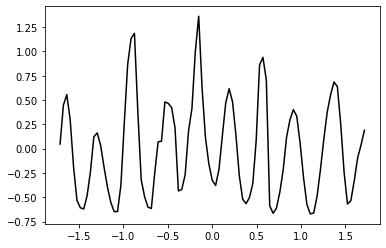

In [367]:
from sklearn.linear_model import Ridge


# linear regression on data
lin_reg = Ridge()
lin_reg.fit(train_x, train_y)

preds = lin_reg.predict(lynx_test)

# MSE 
mse = np.mean((preds - train_y)**2)

# apply RBF kernel to data
from sklearn.gaussian_process.kernels import RBF

# apply RBF kernel 
rbf_kernel = RBF(length_scale = 0.01, length_scale_bounds = (1e-1, 1e3))
x_train_exp = rbf_kernel(train_x)

# fit linear regression
lin_reg = Ridge()
lin_reg.fit(x_train_exp, train_y)

# plot regression
preds_lpm = lin_reg.predict(rbf_kernel(lynx_test))

# calc MSE
mse_lpm = np.mean((preds_lpm - train_y)**2)

mse

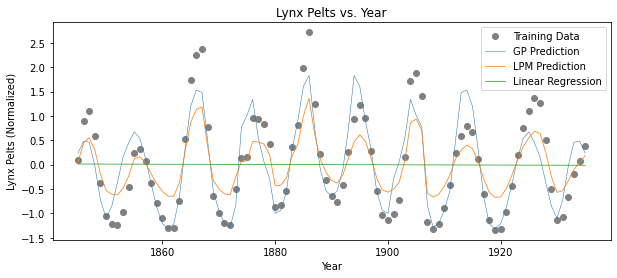

In [365]:
# init fig
fig = plt.figure(figsize = (10,4))


plt.plot(lynx.Year.values, train_y, 'o', label = 'Training Data', color = 'grey', linewidth = 0.75)
plt.plot(lynx.Year.values, m, label = 'GP Prediction', linewidth = 0.5)
plt.plot(lynx.Year.values, preds_lpm, label = 'LPM Prediction', linewidth = 0.75)
# plot linear regression
plt.plot(lynx.Year.values, preds, label = 'Linear Regression', linewidth = 0.75)
# plot error bars
#plt.fill_between(lynx_test.ravel(), m.flatten() - K.flatten(), m.flatten() + K.flatten(), alpha = 0.2)
# add title and labels
plt.title('Lynx Pelts vs. Year')
plt.xlabel('Year')
plt.ylabel('Lynx Pelts (Normalized)')
# legend
plt.legend()

# save fig
plt.savefig('lynx_preds.png', dpi = 200)


In [324]:
# MSE between train_y and m
mse = np.mean((train_y - m)**2)
mse

0.2227309303294774

In [305]:
train_y = lynx.Lynx.values.reshape(-1,1)
lynx_test = lynx.Year.values.reshape(-1,1)

# Standardize train data
train_x = (train_x - train_x.mean()) / train_x.std()
train_y = (train_y - train_y.mean()) / train_y.std()

lynx_test = (lynx_test - lynx_test.mean()) / lynx_test.std()


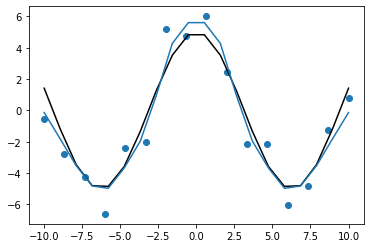

In [228]:
L = 24 # number of layers
n_training = 16
n_test = 20
sigma_w = 1
sigma_b = 1
eps = 1

def signal(x):
    return 5*np.cos(0.5*x)

x = np.linspace(-10, 10, n_training).reshape((n_training, 1))
y = signal(x)
y += eps * np.random.randn(n_training, 1)

x_test = np.linspace(-10, 10, n_test).reshape(n_test, 1)

regression = DeepGP(
    x,
    y,
    x_test, L,
    [sigma_w, sigma_b]
    )


regression.train()

m,p = regression.predict()

# draw true signal
plt.plot(x_test, signal(x_test), 'k', label='True signal')

plt.plot(x_test, m)
plt.scatter(x, y)
plt.show()

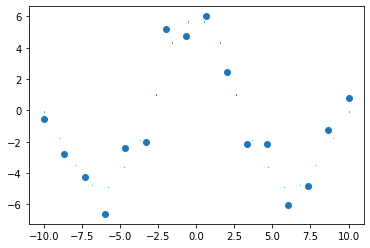

In [231]:
# normal with mean at m and covariance p
for i in range(200):
    preds = np.random.multivariate_normal(m.flatten(), p)
    plt.plot(x_test, preds, ',')

#plot difference
#plt.plot(np.abs(preds - m.flatten()))
# mark training points
plt.scatter(x, y)
plt.show()

In [232]:
np.random.multivariate_normal(m.flatten(), p)

array([-0.13338047, -1.81198285, -3.52800692, -4.821434  , -4.97056543,
       -3.66856768, -1.96427832,  0.95660298,  4.27814313,  5.59783574,
        5.59783574,  4.27814313,  0.95660298, -1.96427832, -3.66856768,
       -4.97056543, -4.821434  , -3.52800692, -1.81198285, -0.13338047])

In [32]:
L = np.arange(1,30)
likelihoods = []
preds = []

for l in L:
    # create and train a DeepGP
    dgp = DeepGP(
        x,
        y,
        x_test,
        l,
        [sigma_w,sigma_b]
    )

    dgp.train()

    m, p = dgp.predict()
    preds.append(m)

    ll = log_likelihood(dgp)
    likelihoods.append(ll)

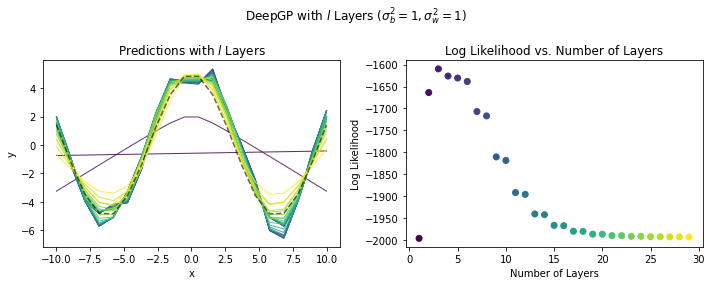

In [33]:
# one color for each L
# subplots
fig, axs = plt.subplots(1,2, figsize=(10,4))

colors = plt.cm.viridis(np.linspace(0, 1, len(L)))

for i in range(len(preds)):
    axs[0].plot(
        x_test, 
        preds[i].flatten(), 
        color = colors[i], 
        label=f"L = {L[i]}",
        linewidth = 1,
        alpha = 0.85)


# map L to colors
axs[1].scatter(L, likelihoods, c=colors)
# add labels
axs[1].set_xlabel("Number of Layers")
axs[1].set_ylabel("Log Likelihood")

# set ax labels
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
# plot true signal
axs[0].plot(x_test, signal(x_test), color = "black", linestyle = "--", alpha = 0.6, label = "True Signal")

#axs[0].legend(loc = "upper left")
# move legend outside of plot
#axs[0].legend(bbox_to_anchor=(-.4, 1), loc='upper left', borderaxespad=0.)
# add title
axs[0].set_title("Predictions with $l$ Layers")

axs[1].set_title("Log Likelihood vs. Number of Layers")
# set overall title
fig.suptitle(f"DeepGP with $l$ Layers $(\sigma_w^2 = {sigma_w}, \sigma_b^2 = {sigma_b})$")
fig.tight_layout()



# save fig
#plt.savefig("deep_gp_regression.png", dpi = 300)

In [53]:
p, ll = MH(dgp, 1000)

Text(4.102532386864334, -9.403414368234023, 'Maximum Likelihood ($(\\sigma_w^2 = 5, \\sigma_b^2 = 1)$)')

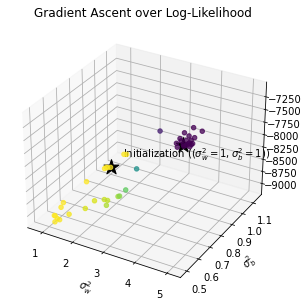

In [246]:
# 3d plot of p, and ll
p = np.array(p)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')

# scale color to ll
c = np.array(ll)
c = c - np.min(c)
c = c / np.max(c)

ax.scatter(p[:,0], p[:,1], ll, c=c, cmap="viridis_r", alpha = 0.75)
# Set title and labels
ax.set_title('Gradient Ascent over Log-Likelihood')
ax.set_xlabel('$\sigma_w^2$')
ax.set_ylabel('$\sigma_b^2$')
# annotate starting point
ax.scatter(p[0][0], p[0][1], ll[0], c = "black", marker = "*", s =250)
# add text annotation
ax.text(p[0,0] + 0.05, p[0,1] + 0.1, ll[0], f"Initialization ($(\sigma_w^2 = {round(p[0,0])}, \sigma_b^2 = {round(p[0,1])})$)", color = "black")

# annotate maximum likelihood
max_ll = np.argmax(ll)
ax.scatter(p[max_ll,0], p[max_ll,1], ll[max_ll], c = "black", marker = "*", s =250)
ax.text(p[max_ll,0] - 0.8, p[max_ll,1] - 10, ll[max_ll], f"Maximum Likelihood ($(\sigma_w^2 = {round(p[max_ll,0])}, \sigma_b^2 = {round(p[max_ll,1])})$)", color = "black")


# rotate plot
#ax.view_init(elev=45., azim=-30)
# mark maximum with lines
# horizontal line
# mark big point

# save fig
#plt.savefig("deep_gp_regression_MH2.png", dpi = 300)


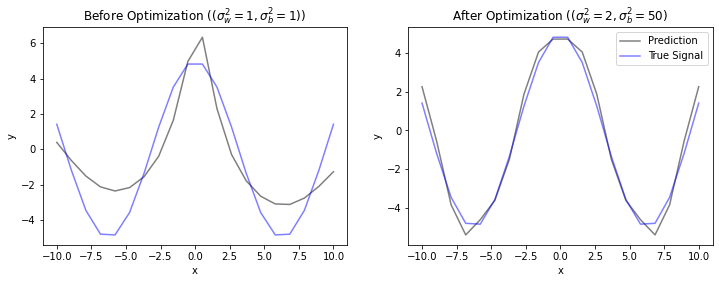

In [99]:
# before/after optimization
# subplots
fig, axs = plt.subplots(1,2, figsize=(12,4))


reg = DeepGP(
    x,
    y,
    x_test,
    layers = 5,
    params = [0.1,0.1])

reg.train()

m, c = reg.predict()


axs[0].plot(x_test, m, color = "black", alpha = 0.5, label = "Prediction")
axs[0].plot(x_test, signal(x_test), color = "blue", alpha = 0.5, label = "True Signal")


reg = DeepGP(
    x,
    y,
    x_test,
    layers = 16,
    params = p[np.argmax(ll)])

reg.train()

m, c = reg.predict()

axs[1].plot(x_test, m, color = "black", alpha = 0.5, label = "Prediction")
# plot true signal
axs[1].plot(x_test, signal(x_test), color = "blue", alpha = 0.5, label = "True Signal")

# Set title and labels
axs[0].set_title(f'Before Optimization ($(\sigma_w^2 = {sigma_w}, \sigma_b^2 = {sigma_b})$) ')
axs[1].set_title(f'After Optimization ($(\sigma_w^2 = {round(p[np.argmax(ll)][0])}, \sigma_b^2 = {round(p[np.argmax(ll)][1])})$')
axs[0].set_xlabel('x')
axs[1].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].set_ylabel('y')

plt.legend()

# save fig
plt.savefig("deep_gp_regression_optimization.png", dpi = 300)


In [ ]:
##### DEPRECATED: Implementation with Recursion ##### 

def kernel_matrix(x, kernel):
    """
    Compute kernel matrix for a given kernel and points x
    """
    N = len(x)
    K = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            K[i,j] = kernel(x[i], x[j])

    K = K + K.T - np.diag(np.diagonal(K))
    return K


class DNNGP:
    def __init__(self, layers, sigma_w, sigma_b):
        self.l = layers
        self.trained = False
        self.sigma_w = sigma_w
        self.sigma_b = sigma_b
    
    def __call__(self, x1, x2):
        self.dnn_kernel(3, x1,x2, 1, 1)

    
    def dnn_kernel(self, l, x1, x2, sigma_b, sigma_w):
        """
        Analytical computation of Recurrence for 
        ReLu activation. 

        Args:
            l : network layer or recurrence level 
            x1: (n_data, d) array
            x2: (n_data, d) array
            sigma_b: float
            sigma_w: float

        Return: 
            kernel
        """

        if l > 0:
            K_xx = self.dnn_kernel(l-1, x1, x1, sigma_b, sigma_w)
            K_yy = self.dnn_kernel(l-1, x2, x2, sigma_b, sigma_w)

            sin_xy = np.sin(self.theta(l-1, x1,x2, sigma_b, sigma_w))
            theta_xy = np.pi - self.theta(l-1, x1,x2, sigma_b, sigma_w)
            cos_xy = np.cos(self.theta(l-1, x1,x2, sigma_b, sigma_w))

            return sigma_b + (sigma_w / (2*np.pi)) * np.sqrt(K_xx * K_yy) * (sin_xy + theta_xy * cos_xy)

        # For first layer
        else: 
            return sigma_b + sigma_w*(x1*x2)

    def theta(self, l, x1, x2, sigma_b, sigma_w):

        """
        Arcosine Kernel in Appendex B
        """

        return np.arccos(
            (self.dnn_kernel(l, x1, x2, sigma_b, sigma_w)) / 
            np.sqrt(
                self.dnn_kernel(l, x1, x1, sigma_b, sigma_w) * 
                self.dnn_kernel(l, x2, x2, sigma_b, sigma_w)
                )
            ) or np.arccos(1)
